In [1]:
import functools
import numpy as np
import pandas as pd
import random
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from simulation.simulation import run_simulation
from features.data_provider import get_train_test_wc_dataset, get_feature_columns, get_whole_dataset

In [2]:
X_train, y_train, X_test, y_test, X_wc, y_wc = get_train_test_wc_dataset("home_win")

Dataset length 39008
Dataset complete cases length 6676
Whole train set length:  5601
Whole test set length:  1075
Whole WC set length:  128


<Figure size 1440x432 with 0 Axes>

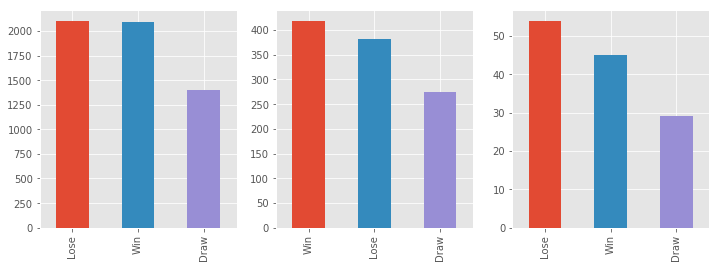

In [3]:
def get_labeled_df(s):
    df = pd.DataFrame(s)
    df[df["home_win"] == 1] = "Win"
    df[df["home_win"] == 0] = "Draw"
    df[df["home_win"] == -1] = "Lose"
    return df

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
pd.value_counts(get_labeled_df(y_train)["home_win"]).plot.bar(ax=axes[0])
pd.value_counts(get_labeled_df(y_test)["home_win"]).plot.bar(ax=axes[1])
pd.value_counts(get_labeled_df(y_wc)["home_win"]).plot.bar(ax=axes[2])

In [4]:
#plt.figure(figsize=(10,10))
#plt.matshow(X_train.corr(), fignum=1)
#X_train.corr()

In [5]:
def get_feature_importance(clf):
    zipped = sorted(zip(get_feature_columns(), clf.feature_importances_), key = lambda t: t[1], reverse=True)
    for feature, importance in zipped:
        print(f"{feature}: {importance}")

In [6]:
def run_grid_search(clf, param_dist, 
                      Xtrain, ytrain, 
                      Xtest, ytest, 
                      X_wc, y_wc,
                      custom_report_for_model=None):
    random_search = GridSearchCV(clf, param_grid=param_dist)
    start = time()
    random_search.fit(Xtrain, ytrain)
    print("TRAIN SET METRICS:")
    print("SCORE: ", random_search.score(Xtrain, ytrain))
    y_true, y_pred = ytrain, random_search.predict(Xtrain)
    print(classification_report(y_true, y_pred))
    print("BEST PARAMS: ", random_search.best_params_)
    print()
    print()
    
    best_clf = random_search.best_estimator_
    best_clf.fit(Xtrain, ytrain)
    
    print("TEST SET METRICS:")
    print("SCORE: ", best_clf.score(Xtest, ytest))
    y_true, y_pred = ytest, best_clf.predict(Xtest)
    print("\n",classification_report(y_true, y_pred))
        
    print()
    print()
    print("WC SET METRICS:")
    print("SCORE: ", random_search.score(X_wc, y_wc))
    y_true, y_pred = y_wc, best_clf.predict(X_wc)
    print("\n",classification_report(y_true, y_pred))
    
    print()
    print()
    if custom_report_for_model:
        custom_report_for_model(best_clf)
    return best_clf

In [7]:
def get_sign_model():
    label = "home_win"
    X_train, y_train, X_test, y_test, X_wc, y_wc = get_train_test_wc_dataset(label)
    clf = RandomForestClassifier(oob_score=True, bootstrap=True, n_jobs=-1)

    param_dist = {"n_estimators": [200],
                  "max_depth": [None],
                  "min_samples_leaf": [5],
                  "max_features": ["sqrt"],
                  "criterion": ["gini"]}
    best_clf = run_grid_search(clf, param_dist,
                                 X_train, y_train, 
                                 X_test, y_test, 
                                 X_wc, y_wc,
                                 custom_report_for_model=get_feature_importance)
    
    X, y = get_whole_dataset(label)
    
    best_clf.fit(X, y)
    return best_clf   

In [11]:
sign_model = get_sign_model()

run_simulation(sign_model)

Dataset length 39008
Dataset complete cases length 6676
Whole train set length:  5601
Whole test set length:  1075
Whole WC set length:  128
TRAIN SET METRICS:
SCORE:  0.90948044992
             precision    recall  f1-score   support

       -1.0       0.90      0.93      0.91      2085
        0.0       0.99      0.83      0.90      1402
        1.0       0.88      0.94      0.91      2114

avg / total       0.91      0.91      0.91      5601

BEST PARAMS:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}


TEST SET METRICS:
SCORE:  0.529302325581

              precision    recall  f1-score   support

       -1.0       0.54      0.71      0.61       408
        0.0       0.28      0.05      0.09       274
        1.0       0.55      0.67      0.60       393

avg / total       0.48      0.53      0.48      1075



WC SET METRICS:
SCORE:  0.53125

              precision    recall  f1-score   support

       -1.0       0.61  

Uruguay - Portugal: -1        -- probabilities [Lose, Draw, Win] -- [ 0.48184796  0.27044886  0.24770318]
France - Croatia: 1        -- probabilities [Lose, Draw, Win] -- [ 0.13530959  0.2486018   0.61608861]
Brazil - Sweden: 1        -- probabilities [Lose, Draw, Win] -- [ 0.11178886  0.17616011  0.71205103]
Belgium - Poland: 1        -- probabilities [Lose, Draw, Win] -- [ 0.21130488  0.25505221  0.53364291]
Spain - Russia: 1        -- probabilities [Lose, Draw, Win] -- [ 0.12094652  0.23149406  0.64755942]
Argentina - Denmark: 1        -- probabilities [Lose, Draw, Win] -- [ 0.273215    0.23073235  0.49605265]
Germany - Switzerland: 1        -- probabilities [Lose, Draw, Win] -- [ 0.19802678  0.27859908  0.52337414]
Colombia - England: -1        -- probabilities [Lose, Draw, Win] -- [ 0.52664007  0.28458632  0.18877361]



___Quarter-Finals___

Portugal - France: -1        -- probabilities [Lose, Draw, Win] -- [ 0.44422514  0.27130407  0.28447079]
Brazil - Belgium: 1        -- proba

In [9]:
from simulation.simulation import post_simulation
post_simulation()